## Prfpy example

Here I illustrate very simple usage of the prfpy API.

Essentially, I:

1. Create an arbitrary bar stimulus as our design matrix.
2. Create a stimulus class.
3. Create a model, which is used to generate predictions.
4. Create some fake data, which is just generated by adding noise to these predictions.
5. Perform the fitting.
6. Refine the fitting.


In [1]:
 %load_ext autoreload
 %autoreload 2

from pRF_sim.stim import simulate_bar_stimulus

I first load specifications for a 'bar' stimulus from a yaml file.

In [2]:
from pRF_sim.utils import load_pkg_yaml

In [3]:
nm=load_pkg_yaml()

In [4]:
nm['bar']

{'num_blank_steps': 30,
 'num_bar_steps': 30,
 'viewing_distance': 38,
 'ecc': 12,
 'pixels_across': 100,
 'pixels_down': 100,
 'thetas': [-1, 0, 90, 180, 270, -1],
 'screen_width': 25}

In [5]:
mybar=simulate_bar_stimulus(**nm['bar'])

The bar is 100 pixels, by 100 pixels. There are 180 time points.

In [36]:
mybar.shape

(100, 100, 180)

I plot this bar, which is our design matrix. 

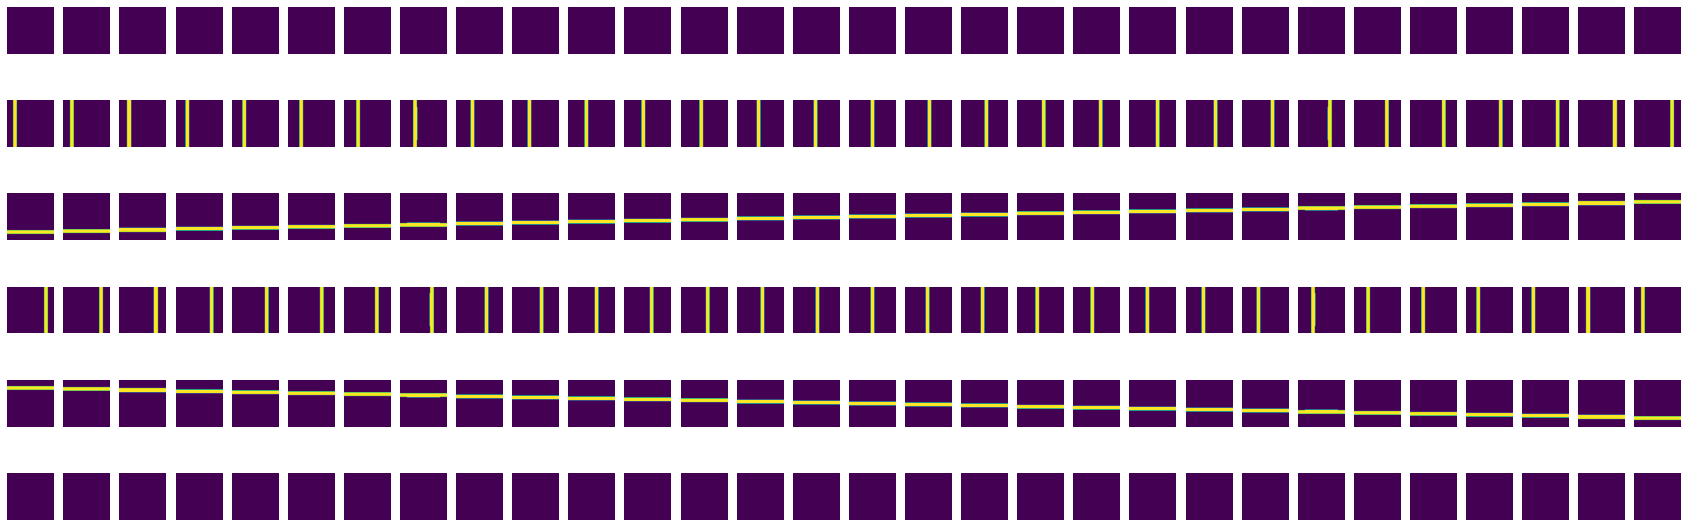

In [37]:
import matplotlib.pyplot as plt

f, ss = plt.subplots(6,30, figsize=(30,10))
shp = 0
for i in range(6):
    for j in range(30):
        ss[i,j].imshow(mybar[:,:,shp])
        ss[i,j].axis('off')
        shp += 1

Using this, and basic information about the experimental display, I now create a PRFStimulus2D class.

In [6]:
from prfpy.stimulus import PRFStimulus2D
prf_stimulus=PRFStimulus2D(screen_size_cm=nm['bar']['screen_width'],
                 screen_distance_cm=nm['bar']['viewing_distance'],
                 design_matrix=mybar,
                 TR=1)

/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/site-packages/prfpy/model.py:3: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


This creates the cartesian mapping of the stimulus space.

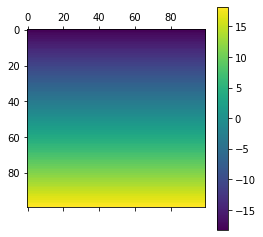

In [8]:
import matplotlib.pyplot as plt
plt.matshow(prf_stimulus.y_coordinates)
plt.colorbar()

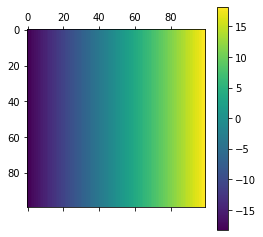

In [13]:
plt.matshow(prf_stimulus.x_coordinates)
plt.colorbar()

And also polar mapping.

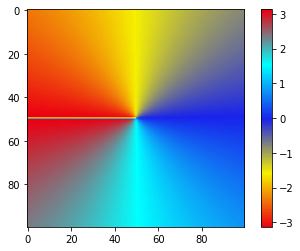

In [10]:
import cortex
plt.imshow(prf_stimulus.polar_coordinates,cmap=cortex.utils.get_cmap('Retinotopy_RYBCR'))
plt.colorbar()

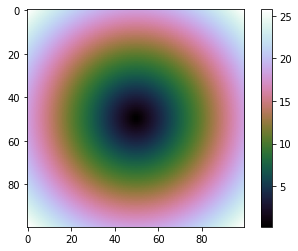

In [12]:
plt.imshow(prf_stimulus.ecc_coordinates,cmap=cortex.utils.get_cmap('cubehelix'))
plt.colorbar()

Using this, I can make a model class. 

In [20]:
from prfpy.model import Iso2DGaussianModel
mod=Iso2DGaussianModel(prf_stimulus,normalize_RFs=True)

Which allows me to make arbitrary predictions for a pRF (parameterized by mu_x,mu_y,size,beta,baseline).
Here I plot the prediction for a pRF that spans almost all of the display (10 DVA) and one with a sigma of 1 DVA.

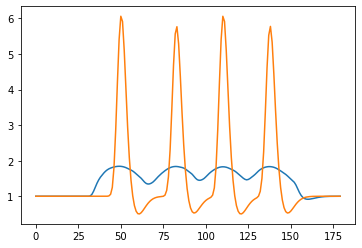

In [26]:
plt.plot(mod.return_prediction(*np.array([0,2,10,1,1]))[0])
plt.plot(mod.return_prediction(*np.array([0,2,1,1,1]))[0])

The function that generates the prf profiles is gauss2D_iso_cart, which allows prf profiles to be visualised as follows.

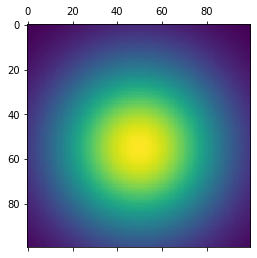

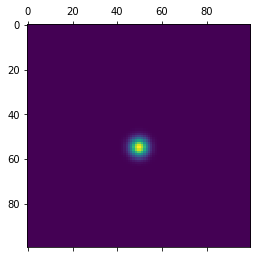

In [27]:
from prfpy.rf import gauss2D_iso_cart
import numpy as np
rf1=gauss2D_iso_cart(x=prf_stimulus.x_coordinates[..., np.newaxis],
                              y=prf_stimulus.y_coordinates[..., np.newaxis],
                              mu=(0,2),
                              sigma=10,)
rf2=gauss2D_iso_cart(x=prf_stimulus.x_coordinates[..., np.newaxis],
                              y=prf_stimulus.y_coordinates[..., np.newaxis],
                              mu=(0,2),
                              sigma=1,)

plt.matshow(rf1[:,:,0])
plt.matshow(rf2[:,:,0])

For now, I will simulate data by adding some noise to one of these predictions.

In [29]:
from prfpy.timecourse import generate_arima_noise

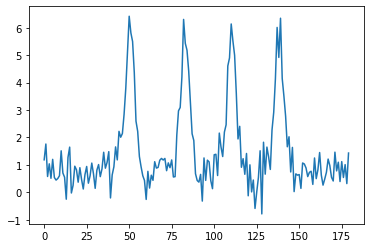

In [80]:
noise=generate_arima_noise(dimensions=(prf_stimulus.design_matrix.shape[-1],1),scale=.5)
data=mod.return_prediction(*np.array([0,2,1,1,1]))[0]+noise.T[0]
data=data.reshape(1,180)
plt.plot(data[0])

As for fitting, I can initially perform a coarse grid fit. I can span the eccentricity and polar angle space (as well as some sigma values) to make a set of grid predicitons. 

In [95]:
ecc_grid=np.linspace(np.min(prf_stimulus.ecc_coordinates),np.max(prf_stimulus.ecc_coordinates),8)
polar_grid=np.linspace(np.min(prf_stimulus.polar_coordinates),np.max(prf_stimulus.polar_coordinates),8)
sigma_grid=np.linspace(.2,10,8)

In [96]:
mod.create_grid_predictions(ecc_grid,polar_grid,sigma_grid)

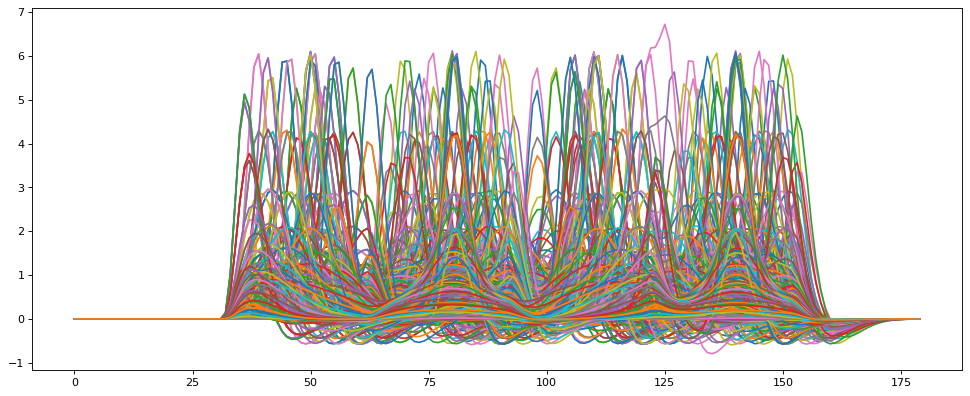

In [97]:
%matplotlib inline
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)

plt.plot(mod.predictions.T);

I can test these predictions my defining a fitter.

In [98]:
from prfpy.fit import Iso2DGaussianFitter

Which takes the data I want to fit and the model as inputs.

In [99]:
myfitter=Iso2DGaussianFitter(data=data, model=mod, n_jobs=20)

I then perform the grid fitting as follows, specifying the same grid as before. 

In [100]:
myfitter.grid_fit(ecc_grid=ecc_grid,polar_grid=polar_grid,size_grid=sigma_grid)

We can then view the best grid params as follows.

In [106]:
myfitter.gridsearch_params

array([[0.05897665, 0.25333356, 1.6       , 1.02383387, 0.90032434,
        0.76853371]])

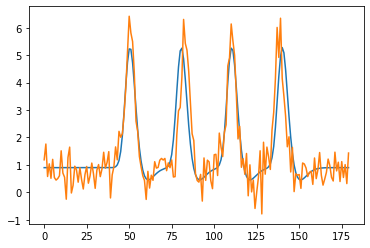

In [102]:
plt.plot(mod.return_prediction(*myfitter.gridsearch_params[0])[0])
plt.plot(data[0])

 We achieve an R2 of .76. It seems we can do much better. Our grids are quite coarse, so this is to be expected.

We can refine this via an interative fit. 

In [108]:
myfitter.iterative_fit(rsq_threshold=0)

In [109]:
myfitter.iterative_search_params

array([[0.08405433, 1.86328207, 1.15708418, 1.03507593, 0.89530551,
        0.900884  ]])

The resulting fit is an order of magnitude better. 

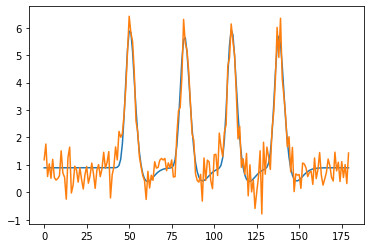

In [110]:
plt.plot(mod.return_prediction(*myfitter.iterative_search_params[0])[0])
plt.plot(data[0])